In [186]:
"""This code is mostly taken and adapted from flowpy.

https://gitlab-research.centralesupelec.fr/2018seznecm/flowpy
"""

#
# Original license below
#
# MIT License
#
# Copyright (c) 2020 Univ. Paris-Saclay, CNRS, CentraleSupelec,
#                    Thales Research & Technology
#
# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
# OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
# SOFTWARE.


import numpy as np
from pathlib import Path
from warnings import warn
import png
import struct
from collections import namedtuple
from itertools import accumulate

DEFAULT_TRANSITIONS = (15, 6, 4, 11, 13, 6)


def flow_to_rgb(
    flow, flow_max_radius=None, background="bright", custom_colorwheel=None
):
    """
    Creates a RGB representation of an optical flow.

    Parameters
    ----------
    flow: numpy.ndarray
        3D flow in the HWF (Height, Width, Flow) layout.
        flow[..., 0] should be the x-displacement
        flow[..., 1] should be the y-displacement

    flow_max_radius: float, optional
        Set the radius that gives the maximum color intensity, useful for comparing different flows.
        Default: The normalization is based on the input flow maximum radius.

    background: str, optional
        States if zero-valued flow should look 'bright' or 'dark'
        Default: "bright"

    custom_colorwheel: numpy.ndarray
        Use a custom colorwheel for specific hue transition lengths.
        By default, the default transition lengths are used.

    Returns
    -------
    rgb_image: numpy.ndarray
        A 2D RGB image that represents the flow

    Raises
    ------
    ValueError
        If the background is invalid.

    See Also
    --------
    make_colorwheel

    """
    valid_backgrounds = ("bright", "dark")
    if background not in valid_backgrounds:
        raise ValueError(
            f"background should be one the following: {valid_backgrounds}, not {background}"
        )

    wheel = make_colorwheel() if custom_colorwheel is None else custom_colorwheel

    complex_flow = flow[..., 0] + 1j * flow[..., 1]
    complex_flow, nan_mask = replace_nans(complex_flow)

    radius, angle = np.abs(complex_flow), np.angle(complex_flow)

    if flow_max_radius is None:
        flow_max_radius = np.max(radius)

    if flow_max_radius > 0:
        radius /= flow_max_radius   # nomarlize


    ncols = len(wheel)

    # Map the angles from (-pi, pi] to [0, 2pi) to [0, ncols - 1)
    angle[angle < 0] += 2 * np.pi
    
    angle = angle * ((ncols - 1) / (2 * np.pi))

    # Make the wheel cyclic for interpolation
    wheel = np.vstack((wheel, wheel[0]))

    # Interpolate the hues
    (angle_fractional, angle_floor), angle_ceil = np.modf(angle), np.ceil(angle)
    angle_fractional = angle_fractional.reshape((angle_fractional.shape) + (1,))
    float_hue = (
        wheel[angle_floor.astype(np.int32)] * (1 - angle_fractional)
        + wheel[angle_ceil.astype(np.int32)] * angle_fractional
    )
    ColorizationArgs = namedtuple(
        "ColorizationArgs",
        ["move_hue_valid_radius", "move_hue_oversized_radius", "invalid_color"],
    )

    def move_hue_on_V_axis(hues, factors):
        return hues * np.expand_dims(factors, -1)

    def move_hue_on_S_axis(hues, factors):
        return 255.0 - np.expand_dims(factors, -1) * (255.0 - hues)

    if background == "dark":
        parameters = ColorizationArgs(
            move_hue_on_V_axis,
            move_hue_on_S_axis,
            np.array([255, 255, 255], dtype=np.float32),
        )
    else:
        parameters = ColorizationArgs(
            move_hue_on_S_axis,
            move_hue_on_V_axis,
            np.array([0, 0, 0], dtype=np.float32),
        )

    colors = parameters.move_hue_valid_radius(float_hue, radius)

    oversized_radius_mask = radius > 1
    colors[oversized_radius_mask] = parameters.move_hue_oversized_radius(
        float_hue[oversized_radius_mask], 1 / radius[oversized_radius_mask]
    )
    colors[nan_mask] = parameters.invalid_color

    return colors.astype(np.uint8)


def make_colorwheel(transitions=DEFAULT_TRANSITIONS):
    """
    Creates a color wheel.

    A color wheel defines the transitions between the six primary hues:
    Red(255, 0, 0), Yellow(255, 255, 0), Green(0, 255, 0), Cyan(0, 255, 255), Blue(0, 0, 255) and Magenta(255, 0, 255).

    Parameters
    ----------
    transitions: sequence_like
        Contains the length of the six transitions.
        Defaults to (15, 6, 4, 11, 13, 6), based on humain perception.

    Returns
    -------
    colorwheel: numpy.ndarray
        The RGB values of the transitions in the color space.

    Notes
    -----
    For more information, take a look at
    https://web.archive.org/web/20051107102013/http://members.shaw.ca/quadibloc/other/colint.htm

    """

    colorwheel_length = sum(transitions)

    # The red hue is repeated to make the color wheel cyclic
    base_hues = map(
        np.array,
        (
            [255, 0, 0],
            [255, 255, 0],
            [0, 255, 0],
            [0, 255, 255],
            [0, 0, 255],
            [255, 0, 255],
            [255, 0, 0],
        ),
    )

    colorwheel = np.zeros((colorwheel_length, 3), dtype="uint8")
    hue_from = next(base_hues)
    start_index = 0
    for hue_to, end_index in zip(base_hues, accumulate(transitions)):
        transition_length = end_index - start_index

        colorwheel[start_index:end_index] = np.linspace(
            hue_from, hue_to, transition_length, endpoint=False
        )
        hue_from = hue_to
        start_index = end_index

    return colorwheel


def replace_nans(array, value=0):
    nan_mask = np.isnan(array)
    array[nan_mask] = value

    return array, nan_mask

In [192]:
import numpy as np

def rgb_to_flow(rgb_image, flow_max_radius, custom_colorwheel=None):
    """
    Converts a RGB representation of an optical flow back to the flow data.

    Parameters
    ----------
    rgb_image: numpy.ndarray
        2D RGB image that represents the flow
    flow_max_radius: float, optional
        The radius that gives the maximum color intensity, useful for comparing different flows.
        Default: 30
    custom_colorwheel: numpy.ndarray
        Use a custom colorwheel for specific hue transition lengths.
        By default, the default transition lengths are used.

    Returns
    -------
    flow: numpy.ndarray
        3D flow in the HWF (Height, Width, Flow) layout.
        flow[..., 0] is the x-displacement
        flow[..., 1] is the y-displacement

    See Also
    --------
    flow_to_rgb, make_colorwheel
    """
    wheel = make_colorwheel() if custom_colorwheel is None else custom_colorwheel
    ncols = len(wheel)

    # Normalize the RGB image
    rgb_image = rgb_image.astype(np.float32) / 255.0

    # Find the angles and magnitudes from the color wheel
    wheel = np.vstack((wheel, wheel[0]))

    angle = np.zeros((rgb_image.shape[0], rgb_image.shape[1]), dtype=np.float32)
    radius = np.zeros_like(angle)

    for i in range(ncols):
        diff = np.linalg.norm(rgb_image - wheel[i], axis=-1)
        mask = diff < np.linalg.norm(rgb_image - wheel[(i + 1) % ncols], axis=-1)
        # angle[mask] = (i + diff[mask] / (diff[mask] + np.linalg.norm(rgb_image[mask] - wheel[(i + 1) % ncols], axis=-1))) * (2 * np.pi / ncols)
        angle[mask] = (i + diff[mask] / (diff[mask] + np.linalg.norm(rgb_image[mask] - wheel[(i + 1) % ncols], axis=-1)))  / ncols

    # Compute radius from the RGB values
    max_rgb = np.max(rgb_image, axis=-1)
    min_rgb = np.min(rgb_image, axis=-1)
    radius = max_rgb - min_rgb

    # Reverse the angle and radius normalization
    radius *= flow_max_radius

    # Convert polar coordinates back to cartesian coordinates
    flow_x = radius * np.cos(angle)
    flow_y = radius * np.sin(angle)

    # Combine the flow channels
    flow = np.dstack((flow_x, flow_y))

    return flow




In [193]:
# import flow_to_rgb
from ptlflow.utils import flow_utils
from ptlflow.utils.flow_utils import flowpy
import cv2
import numpy as np
import matplotlib.pyplot as plt

flow = flow_utils.flow_read('/workspace/data/Gopro_my_2/test/000008/flow/flows/000008.flo')
complex_flow = flow[..., 0] + 1j * flow[..., 1]
complex_flow, nan_mask = replace_nans(complex_flow)

radius, angle = np.abs(complex_flow), np.angle(complex_flow)
print(np.max(radius))

flow_rgb = flow_to_rgb(flow)
print(flow.shape)
print(flow_rgb.shape)

18.385784
(720, 1280, 2)
(720, 1280, 3)


In [194]:
flow_recon = rgb_to_flow(flow_rgb,np.max(radius))
print(flow_recon)

UFuncTypeError: Cannot cast ufunc 'multiply' output from dtype('float32') to dtype('uint8') with casting rule 'same_kind'

In [176]:
flow

array([[[-3.2054102 ,  9.45139   ],
        [-3.2026527 ,  9.444965  ],
        [-3.2002544 ,  9.440423  ],
        ...,
        [-3.9538987 ,  8.562265  ],
        [-3.9562464 ,  8.563152  ],
        [-3.954883  ,  8.563545  ]],

       [[-3.2063677 ,  9.451735  ],
        [-3.204085  ,  9.44499   ],
        [-3.2023344 ,  9.439701  ],
        ...,
        [-3.9518905 ,  8.559059  ],
        [-3.9542112 ,  8.560066  ],
        [-3.9528258 ,  8.560434  ]],

       [[-3.2079172 ,  9.450844  ],
        [-3.206252  ,  9.444205  ],
        [-3.20482   ,  9.438588  ],
        ...,
        [-3.948537  ,  8.555796  ],
        [-3.9503078 ,  8.556799  ],
        [-3.9491625 ,  8.5569105 ]],

       ...,

       [[-5.859589  , 11.949978  ],
        [-5.862648  , 11.9503145 ],
        [-5.866679  , 11.946738  ],
        ...,
        [-0.79461586,  8.937222  ],
        [-0.7749955 ,  8.90663   ],
        [-0.74092025,  8.864708  ]],

       [[-5.8659706 , 11.948713  ],
        [-5.86924   , 11.94

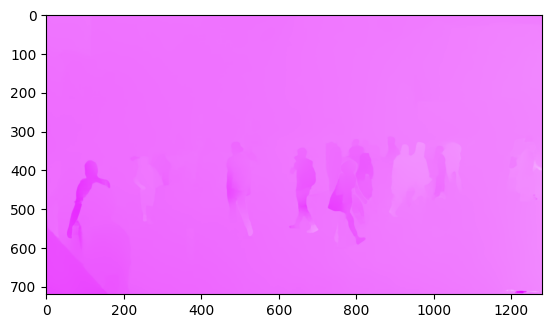

In [177]:
flow_recon_rgb = flow_to_rgb(flow_recon)
plt.imshow(flow_recon_rgb)

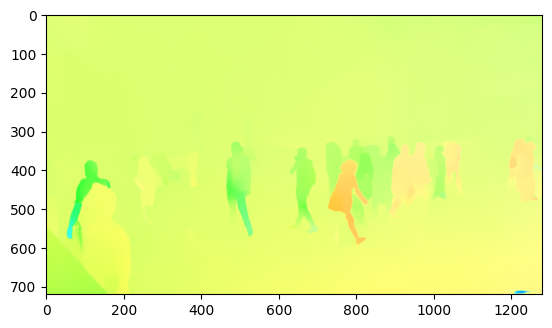

In [178]:
plt.imshow(flow_rgb)